In [1]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from matplotlib.ticker import FuncFormatter

In [2]:
path = os.getcwd()
parent_path = os.path.dirname(path)

df_housing = pd.read_csv(f"{parent_path}/datasets/housing_data_clean.csv")
df_crimes = pd.read_csv(f"{parent_path}/datasets/non_danish_crime_per_capita.csv", sep=";")

In [3]:
df_housing.head()

,date,year_build,purchase_price,city,municipality
0,2014,1965,1500000,Lejre,Lejre
1,2014,1942,1300000,Hundested,Halsnæs
2,2014,1875,1145000,Nykøbing Sj,Odsherred
3,2014,1972,1105000,Vejby,Gribskov
4,2014,1921,3700000,København NV,Copenhagen


In [4]:
df_crimes.head()

,municipality,year,non_danish_population,danish_population,crime_count,total_population,non_danish_ratio,crime_rate_per_1000
0,Albertslund,2014,6190,20174,2779,26364,0.234790,105.408891
1,Albertslund,2015,6214,20142,2584,26356,0.235772,98.042192
2,Albertslund,2016,6231,20180,2767,26411,0.235924,104.766953
3,Albertslund,2017,6341,20011,2538,26352,0.240627,96.311475
4,Albertslund,2018,6416,19848,2507,26264,0.244289,95.453853


In [5]:
# Ensure that municipalities match
housing_munis = set(df_housing["municipality"].unique())
crime_munis = set(df_crimes["municipality"].unique())

mismatches = housing_munis.symmetric_difference(crime_munis)

print("The number of municipalities in Hovedstaden + Zealand is 45.")
print(f"The number of municipalities in the prices housing dataset is: {len(housing_munis)}.")
print(f"The number of municipalities in the crimes dataset is: {len(crime_munis)}.")
print(f"The discrepancy in municipalities between the datasets is: {mismatches}. This means that these municapalities do not have a record in the prices housing dataset.")

The number of municipalities in Hovedstaden + Zealand is 45.
The number of municipalities in the prices housing dataset is: 45.
The number of municipalities in the crimes dataset is: 46.
The discrepancy in municipalities between the datasets is: {'Bornholm'}. This means that these municapalities do not have a record in the prices housing dataset.


In [6]:
# Merge the dataframes
# Left: refers to `df_housing`
# Right: refers to `df_crimes`
# Takes a row from the left df and scans the right df until it finds a match
merged_df = pd.merge(
    df_housing,
    df_crimes,
    left_on=["municipality", "date"],
    right_on=["municipality", "year"],
    how="inner"
)

merged_df = merged_df.drop(columns=["year"])

In [7]:
merged_df.head(10)

,date,year_build,purchase_price,city,municipality,non_danish_population,danish_population,crime_count,total_population,non_danish_ratio,crime_rate_per_1000
0,2014,1965,1500000,Lejre,Lejre,805,25635,1270,26440,0.030446,48.033283
1,2014,1942,1300000,Hundested,Halsnæs,1979,27936,2358,29915,0.066154,78.823333
2,2014,1875,1145000,Nykøbing Sj,Odsherred,832,31038,2275,31870,0.026106,71.383746
3,2014,1972,1105000,Vejby,Gribskov,1632,38301,3149,39933,0.040868,78.857086
4,2014,1921,3700000,København NV,Copenhagen,81723,442064,97983,523787,0.156023,187.066498
5,2014,1968,977500,Sjællands Odde,Odsherred,832,31038,2275,31870,0.026106,71.383746
6,2014,1980,613500,Væggerløse,Guldborgsund,2752,56996,5026,59748,0.046060,84.119971
7,2014,1940,1050000,Vanløse,Copenhagen,81723,442064,97983,523787,0.156023,187.066498
8,2014,1920,450000,Stege,Vordingborg,1622,42914,3077,44536,0.036420,69.090174
9,2014,2011,2525000,Lille Skensved,Køge,4561,52986,5097,57547,0.079257,88.571081


In [8]:
merged_df.shape

(337512, 11)

In [9]:
### ------------------------------- Research question -------------------------------
### To what extent does criminal activity influence the housing market in the Zealand and Capital Regions of Denmark?
### ---------------------------------------------------------------------------------

In [10]:
# Group by `municipality` and calculate the medians of `purchase_price` and `crime_count`
cluster_data = merged_df.groupby("municipality")[["purchase_price", "crime_rate_per_1000"]].median()

print(cluster_data)

                purchase_price  crime_rate_per_1000
municipality                                       
Albertslund          2700000.0            96.434675
Allerød              3400000.0            71.371130
Ballerup             3100000.0            80.168685
Brøndby              3095000.0            91.690111
Copenhagen           3450000.0           153.815491
Dragør               3875000.0            40.404760
Egedal               2855555.0            41.882680
Faxe                 1575000.0            47.822903
Fredensborg          2970000.0            47.760185
Frederiksberg        3950000.0            80.784075
Frederikssund        1800000.0            55.860744
Furesø               3800000.0            54.656427
Gentofte             4995000.0            73.512883
Gladsaxe             3100000.0            71.188071
Glostrup             2800000.0           113.430466
Greve                3145000.0            65.760948
Gribskov             1995000.0            62.567233
Guldborgsund

In [11]:
# --------------------------- K-MEANS ---------------------------

# Normalize
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cluster_data)


# --- ELBOW METHOD

from kneed import KneeLocator

# Elbow method to find the optimal number of clusters.
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

In [12]:
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "pgf.rcfonts": False,
    "pgf.texsystem": "pdflatex",
    "text.latex.preamble": r"\usepackage{amsmath}",
})

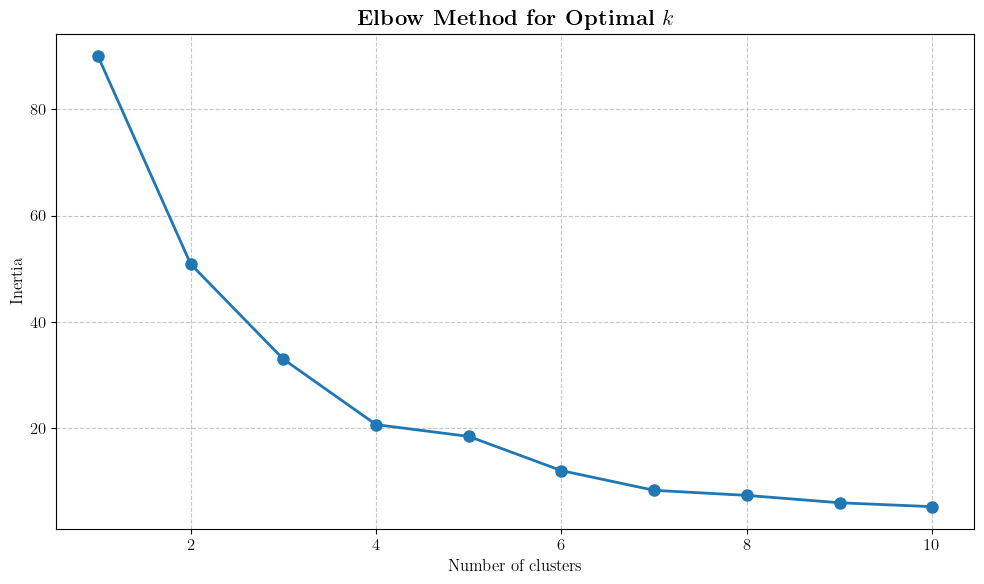

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(K, inertia, "o-", markersize=8, linewidth=2)

ax.set_xlabel(r"Number of clusters")
ax.set_ylabel(r"Inertia")
ax.set_title(r"\textbf{Elbow Method for Optimal $k$}")
ax.grid(True, linestyle="--", alpha=0.7)

fig.tight_layout()
fig.savefig("elbow_method.pgf")
plt.show()


In [14]:

# Define the colors to be used in the plot.
colors = [
    "#2580B7", # Blue
    "#F59B11", # Yellow
    "#9EBE5B", # Light Green
    "#C03B26", # Red
    "#633248", # Brown
    "#44546A", # Gray
    "#179E86", # Dark Green
    
    
]

# Use the KneeLocator from the kneed library to find the elbow point.
kl = KneeLocator(K, inertia, curve="convex", direction="decreasing")
elbow_point = kl.elbow
print(f"The optimal number of clusters is: {elbow_point}.")

The optimal number of clusters is: 4.


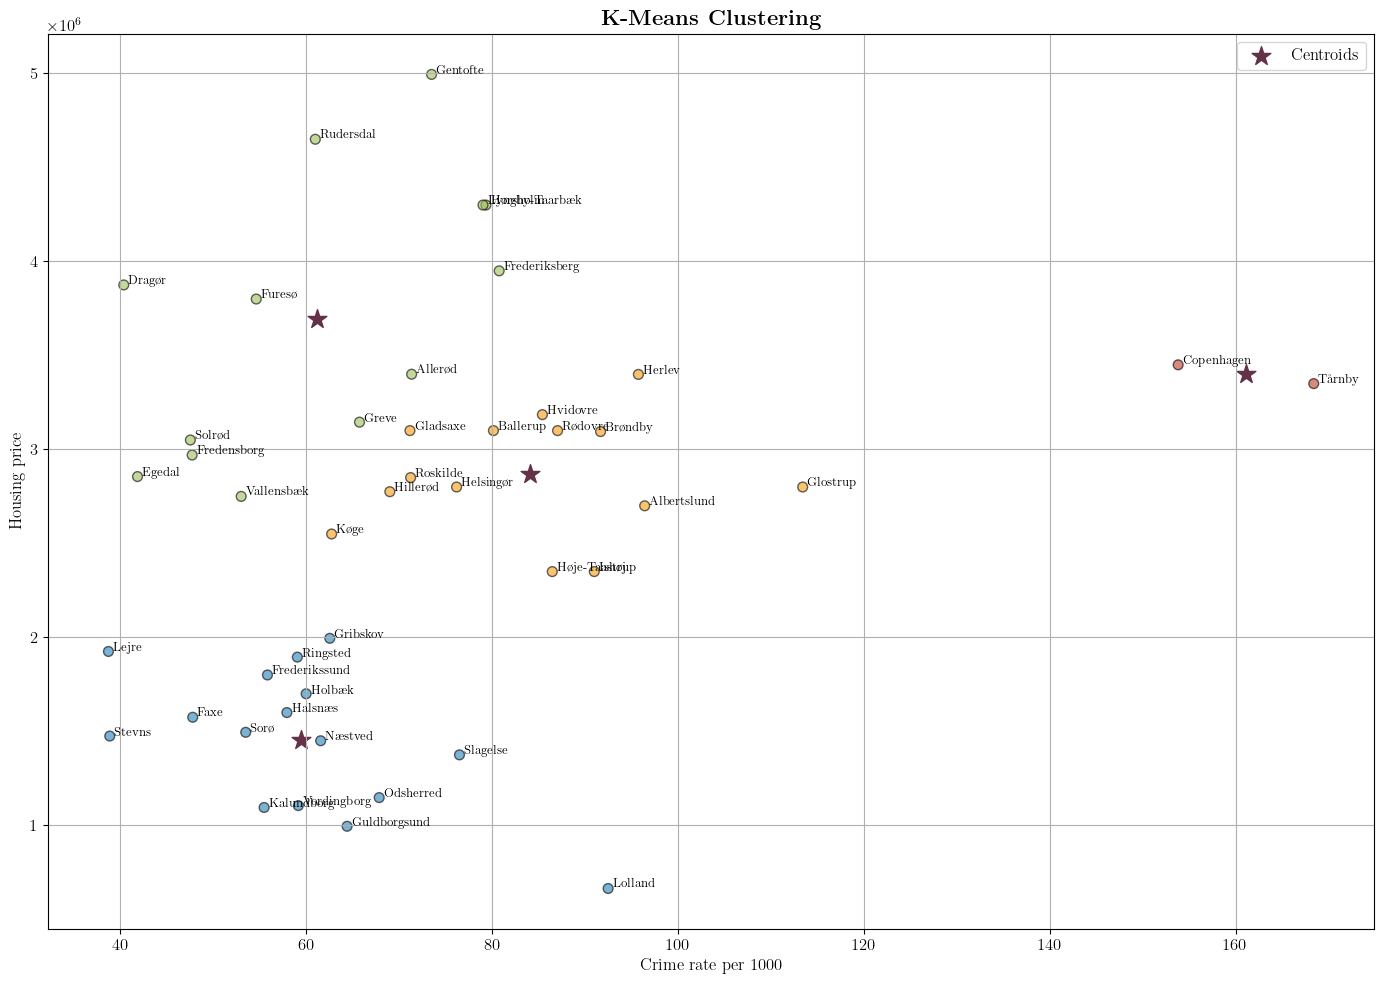

Cluster 0 has 16 municipalities.
Cluster 1 has 14 municipalities.
Cluster 2 has 13 municipalities.
Cluster 3 has 2 municipalities.


In [15]:
# Apply the k-means algorithm.
kmeans = KMeans(n_clusters=elbow_point, random_state=42)
kmeans.fit(data_scaled)

# We use inverse_transform to convert the calculated centroids 
# from the "scaled" values used by the algorithm back into real-world units 
# so they could be plotted correctly.
centers_real = scaler.inverse_transform(kmeans.cluster_centers_)

# # Plot the data points and the centroids.
fig, ax = plt.subplots(figsize=(14, 10))

ax.scatter(
    cluster_data.iloc[:, 1],
    cluster_data.iloc[:, 0],
    c=[colors[int(label) % len(colors)] for label in kmeans.labels_],
    s=50,
    edgecolor="black",
    alpha=0.6,
)

ax.scatter(
    centers_real[:, 1],
    centers_real[:, 0],
    s=200,
    c=colors[4],
    marker="*",
    label="Centroids",
)

for muni in cluster_data.index:
    ax.text(
        cluster_data.loc[muni, "crime_rate_per_1000"] + 0.5,
        cluster_data.loc[muni, "purchase_price"],
        muni,
        fontsize=9,
    )

ax.set_title(r"\textbf{K-Means Clustering}")
ax.set_xlabel(r"Crime rate per 1000")
ax.set_ylabel(r"Housing price")
ax.legend()
ax.grid(True)

fig.tight_layout()
fig.savefig("kmeans_clustering.pgf")
plt.show()

# Turn clusters into separate lists of municipalities

cluster_data["Cluster"] = kmeans.labels_

cluster_0 = cluster_data[cluster_data["Cluster"] == 0].index.tolist()
cluster_1 = cluster_data[cluster_data["Cluster"] == 1].index.tolist()
cluster_2 = cluster_data[cluster_data["Cluster"] == 2].index.tolist()
cluster_3 = cluster_data[cluster_data["Cluster"] == 3].index.tolist()

print(f"Cluster 0 has {len(cluster_0)} municipalities.")
print(f"Cluster 1 has {len(cluster_1)} municipalities.")
print(f"Cluster 2 has {len(cluster_2)} municipalities.")
print(f"Cluster 3 has {len(cluster_3)} municipalities.")

**RESULTS**

**Cluster 0 (Bottom Left)**

- Characteristics: Low Prices (~1m - 2m DKK) and Low-to-Medium Crime.
- Examples: Lolland, Guldborgsund, Kalundborg.
- Insight: These areas are safe, but economically less active. Low crime alone does not drive high prices here.

**Cluster 1 (Top Left)**

- Characteristics: High Prices (~3m - 5m DKK) and Low Crime.
- Examples: Gentofte, Rudersdal, Frederiksberg, Dragør.
- Insight: This is the "Ideal" market where high safety correlates with high value. Gentofte is the extreme outlier here—the most expensive municipality by far.

**Cluster 2 (Right Side)**

- Characteristics: Moderate Crime and Moderate prices.
- Examples: Hvidovre, Brondby.
- Insight: These are municipalities where the prices are close to the median and the crime rate is mostly less than the median.
This cluster neighbours very closely to Cluster 1

**Cluster 3 (The outliers)**

- Characteristics: High Crime and High prices.
- Examples: Copenhagen, Tarnby.
- Insight: Copenhagen has the most population so it makes sense to have the most crimes. Also it is the capital and it makes sense to have
high prices, although clearly not the highest. Tarnby became an outlier based on the crimes rate which most probably is affected by the
fact the airport operates in Tarnby, so all the crimes that are reported in the airport belong to the Tarnby municipality.

In [16]:
### --- Outlier Detection

# z-score = (value - average) / standard deviation
# `data_scaled` has the Z-Scored converted prices and crime rates
# we will take the absolute values and find which are less than 3. those are not outliers
# `mask` marks as `true` what satisfies the condition and `false` what is not

mask = (np.abs(data_scaled) < 3).all(axis=1)

print(cluster_data.head(5), end="\n\n")
print(mask[:5], end="\n\n\n")

# we check which rows from `cluster_data` do not satisfy the results from `mask`
# ie which rows have `false` (~mask means "not keep")
outliers_detected = cluster_data[~mask]

print(f"---- Removing {len(outliers_detected)} Municipalities ----", end="\n\n")
print(outliers_detected)

# Apply the mask to BOTH datasets to keep them synced
cluster_data_no_outliers = cluster_data[mask].copy()
data_scaled_no_outliers = data_scaled[mask]

              purchase_price  crime_rate_per_1000  Cluster
municipality                                              
Albertslund        2700000.0            96.434675        1
Allerød            3400000.0            71.371130        2
Ballerup           3100000.0            80.168685        1
Brøndby            3095000.0            91.690111        1
Copenhagen         3450000.0           153.815491        3

[ True  True  True  True False]


---- Removing 2 Municipalities ----

              purchase_price  crime_rate_per_1000  Cluster
municipality                                              
Copenhagen         3450000.0           153.815491        3
Tårnby             3350000.0           168.399874        3


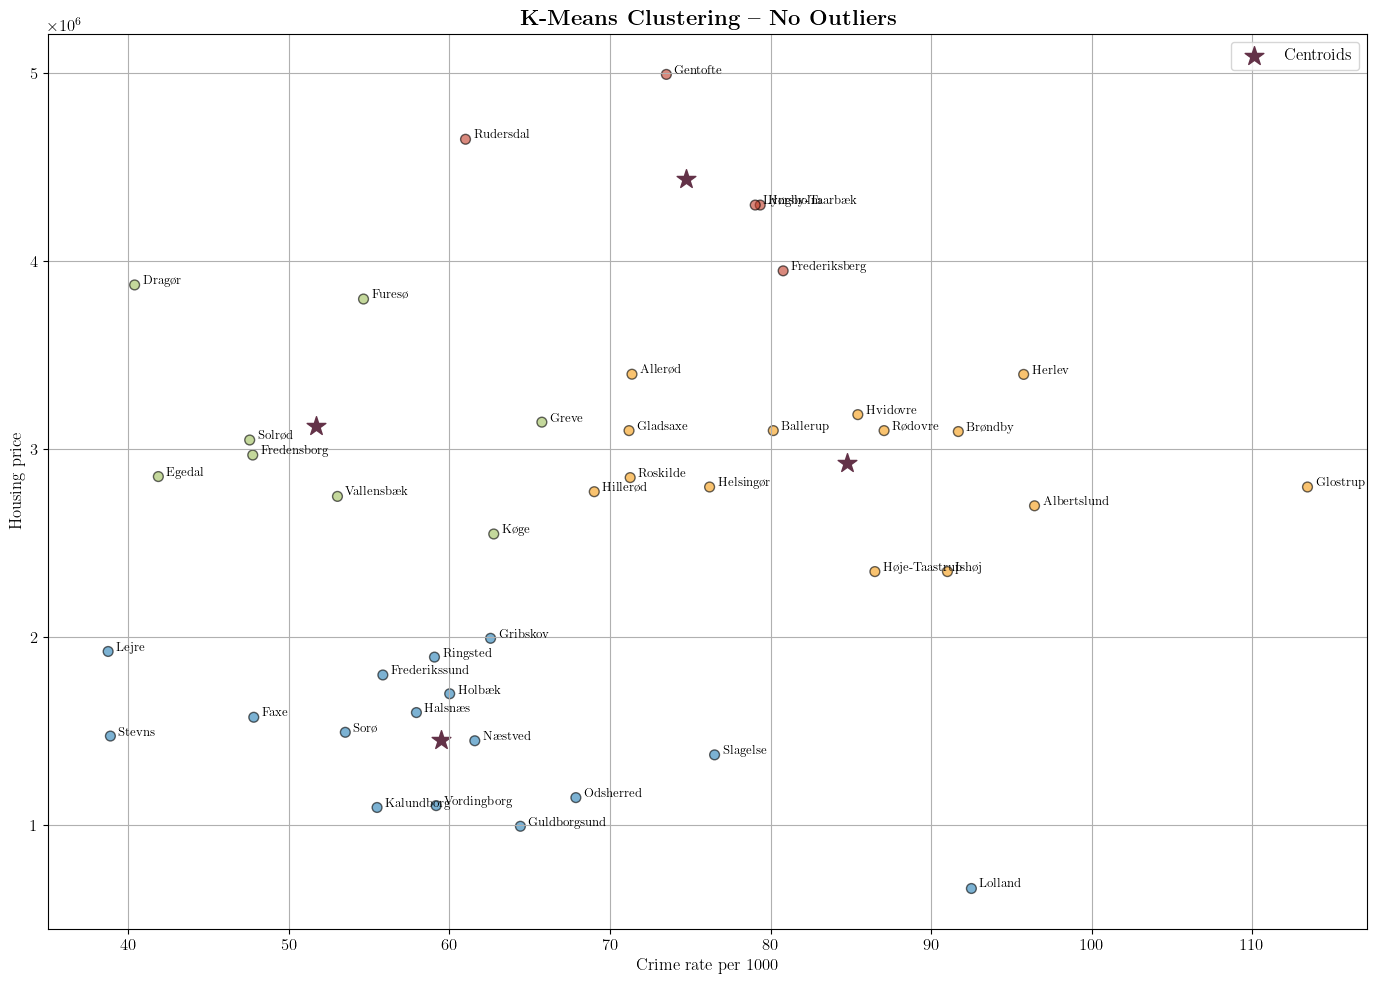

Cluster 0 has 16 municipalities.
Cluster 1 has 14 municipalities.
Cluster 2 has 8 municipalities.
Cluster 3 has 8 municipalities.


In [17]:
# Apply the k-means algorithm without outliers
kmeans = KMeans(n_clusters=elbow_point, random_state=42)
kmeans.fit(data_scaled_no_outliers)

centers_real = scaler.inverse_transform(kmeans.cluster_centers_)

# Plot the data points and the centroids.

fig, ax = plt.subplots(figsize=(14, 10))

ax.scatter(
    cluster_data_no_outliers.iloc[:, 1],
    cluster_data_no_outliers.iloc[:, 0],
    c=[colors[int(label) % len(colors)] for label in kmeans.labels_],
    s=50,
    edgecolor="black",
    alpha=0.6,
)

ax.scatter(
    centers_real[:, 1],
    centers_real[:, 0],
    s=200,
    c=colors[4],
    marker="*",
    label="Centroids",
)

for muni in cluster_data.index.drop(["Copenhagen", "Tårnby"]):
    ax.text(
        cluster_data_no_outliers.loc[muni, "crime_rate_per_1000"] + 0.5,
        cluster_data_no_outliers.loc[muni, "purchase_price"],
        muni,
        fontsize=9,
    )

ax.set_title(r"\textbf{K-Means Clustering -- No Outliers}")
ax.set_xlabel(r"Crime rate per 1000")
ax.set_ylabel(r"Housing price")
ax.legend()
ax.grid(True)

fig.tight_layout()
fig.savefig("kmeans_clustering_no_outliers.pgf")
plt.show()

# Turn clusters into separate lists of municipalities

cluster_data_no_outliers["Cluster"] = kmeans.labels_

cluster_0_noout = cluster_data_no_outliers[cluster_data_no_outliers["Cluster"] == 0].index.tolist()
cluster_1_noout = cluster_data_no_outliers[cluster_data_no_outliers["Cluster"] == 1].index.tolist()
cluster_2_noout = cluster_data_no_outliers[cluster_data_no_outliers["Cluster"] == 2].index.tolist()
cluster_3_noout = cluster_data_no_outliers[cluster_data_no_outliers["Cluster"] == 3].index.tolist()

print(f"Cluster 0 has {len(cluster_0_noout)} municipalities.")
print(f"Cluster 1 has {len(cluster_1_noout)} municipalities.")
print(f"Cluster 2 has {len(cluster_2_noout)} municipalities.")
print(f"Cluster 3 has {len(cluster_2_noout)} municipalities.")



**With the removal of the outliers we can see some noticable changes.**

- A cluster with low prices (bottom) remained the same. Low prices and crime rates from low to almost high.
- A cluster with close to and above median prices and crime rates less than the median.
- A cluster with close to and above median prices and crime rates more than the median.
  
Without the outliers, the centroids setem to be placed more "naturally" in the center of the clusters.


In [18]:
### ------------------------------- Research question -------------------------------
###
### Can we predict a house's price based on the local crime rate?
###
### ---------------------------------------------------------------------------------

In [19]:
def regression(df, feature_list, target="purchase_price", experiment_name="", dataset_type=""):
    
    # Prepare Data
    X = df[feature_list].copy()
    y = df[target]
    
    # Handling Categorical values
    X = pd.get_dummies(X, drop_first=True)
    
    # Data Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    
    # Fit Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        "Dataset": dataset_type,
        "Experiment": experiment_name,
        "Features Used": ", ".join(feature_list),
        "MAE (Error)": mae,
        "R² Score": r2
    }

# Set up data

outliers = ["Copenhagen", "Tårnby"]
df_full = merged_df.copy()
df_clean = merged_df[~merged_df["municipality"].isin(outliers)].copy()

# Running scenarios

results = []

experiments = [
    ("Crime Rate Only", ["crime_rate_per_1000"]),
    ("Year Build Only", ["year_build"]),
    ("Municipality Only", ["municipality"]),
    ("Crime + Year Build + Location", ["crime_rate_per_1000", "year_build", "municipality"]),
    ("Crime + Demographics + Location", ["crime_rate_per_1000", "non_danish_ratio", "municipality"])
]

for name, features in experiments:
    results.append(regression(
        df_full, 
        features, 
        experiment_name=name, 
        dataset_type="With Outliers"
    ))
    
    results.append(regression(
        df_clean, 
        features, 
        experiment_name=name, 
        dataset_type="No Outliers"
    ))


df_results = pd.DataFrame(results).sort_values(by=["R² Score"])

styled_table = df_results.style.format({
    "MAE (Error)": "{:,.0f} DKK",
    "R² Score": "{:.3f}"
})

display(styled_table)

,Dataset,Experiment,Features Used,MAE (Error),R² Score
1,No Outliers,Crime Rate Only,crime_rate_per_1000,"1,511,112 DKK",0.000
3,No Outliers,Year Build Only,year_build,"1,514,913 DKK",0.001
2,With Outliers,Year Build Only,year_build,"1,582,837 DKK",0.002
0,With Outliers,Crime Rate Only,crime_rate_per_1000,"1,548,351 DKK",0.024
4,With Outliers,Municipality Only,municipality,"1,245,927 DKK",0.276
6,With Outliers,Crime + Year Build + Location,"crime_rate_per_1000, year_build, municipality","1,234,543 DKK",0.289
8,With Outliers,Crime + Demographics + Location,"crime_rate_per_1000, non_danish_ratio, municipality","1,223,312 DKK",0.293
5,No Outliers,Municipality Only,municipality,"1,162,290 DKK",0.308
7,No Outliers,Crime + Year Build + Location,"crime_rate_per_1000, year_build, municipality","1,153,220 DKK",0.319
9,No Outliers,Crime + Demographics + Location,"crime_rate_per_1000, non_danish_ratio, municipality","1,139,619 DKK",0.325


**RESULTS:**

**1. Removing Outliers Significantly Improves Accuracy**
- In almost every experiment, the "No Outliers" version (Clean Data) performs better than the "With Outliers" version.
- Best Example: In the "Crime + Demographics + Location" experiment (bottom rows), the $R^2$ Score improves from 0.293 (With Outliers) to 0.325 (No Outliers).


**2. Location is Important ("Municipality Only" vs. "Crime Only")**
- The single most important predictor of house price is Location (Municipality), not Crime Rate.
- Crime Rate Only: $R^2 \approx 0.00 - 0.02$ (The model is basically guessing).
- Municipality Only: $R^2 \approx 0.308$ (The model explains ~30% of the price variation).
- Interpretation: Knowing where a house is (e.g., "It's in Roskilde") is vastly more powerful than knowing the crime rate of that area.
- Crime is a secondary factor, not the primary driver of price.

**3. The Best Model: "Crime + Demographics + Location"**
- The most complex model (Row 9) achieved the highest score: $R^2 = 0.325$.
- This confirms that while Location is the main driver, adding context (Crime Rate + Non-Danish Ratio) does add value, helping the model fine-tune its predictions.
- Error (MAE): The error dropped to 1,139,619 DKK. This means on average, the model is "off" by about 1.1 million DKK. While this seems high, in a market where prices range from 500k to 10M+, it is a decent baseline for a linear model.

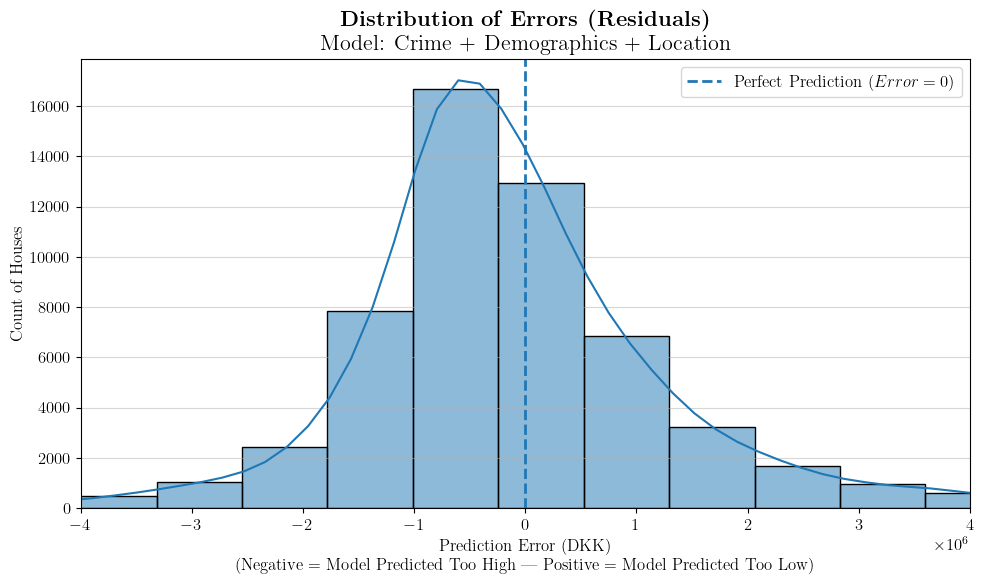

In [20]:
#--- HISTOGRAM

# Re-run the best model (Scenario #9) to get the data
features = ["crime_rate_per_1000", "non_danish_ratio", "municipality"]
X = pd.get_dummies(df_clean[features], drop_first=True)
y = df_clean["purchase_price"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

residuals = y_test - y_pred

fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(residuals, kde=True, bins=50, ax=ax)

ax.axvline(x=0, linestyle="--", linewidth=2, label=r"Perfect Prediction ($Error = 0$)")

ax.set_title(r"\textbf{Distribution of Errors (Residuals)}" + "\n" + r"Model: Crime + Demographics + Location")
ax.set_xlabel(r"Prediction Error (DKK)" + "\n" + r"(Negative = Model Predicted Too High | Positive = Model Predicted Too Low)")
ax.set_ylabel(r"Count of Houses")

ax.legend()
ax.grid(True, axis="y", alpha=0.5)
ax.set_xlim(-4000000, 4000000)

fig.tight_layout()
fig.savefig("residuals_histogram.pgf")
plt.show()